In [48]:
import os
import math
import argparse
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [49]:
a = None
b = None

(a, b) != (None, None)

False

In [50]:
parser = argparse.ArgumentParser(description='Plothole Segmentation')
parser.add_argument("--path", type=str, default=os.path.join(os.getcwd(), "data"), help="Path to the data directory")
args = parser.parse_args(args=[])

In [51]:
path = args.path
if not os.path.exists(path):
    raise ValueError(f"Path {path} does not exist")

In [52]:
imagePath = os.path.join(path, "images")

trainPath = os.path.join(imagePath, "train")
validPath = os.path.join(imagePath, "valid")

trainImagePath = os.path.join(trainPath, "images")
trainLabelsPath = os.path.join(trainPath, "labels")

In [53]:
trainImage = sorted(os.listdir(trainImagePath))
trainLabels = sorted(os.listdir(trainLabelsPath))

if len(trainImage) != len(trainLabels):
    raise ValueError(f"Number of images and labels do not match")

for i in range(len(trainImage)):
    trainImage[i] = trainImage[i][:-4]
    trainLabels[i] = trainLabels[i][:-4]

imageDF = pd.DataFrame({"imageFile": trainImage})
labelDF = pd.DataFrame({"labelFile": trainLabels})

trainDF = pd.merge(imageDF, labelDF, left_on="imageFile", right_on="labelFile", how="inner")

---

## Show segmentation mask (points) 

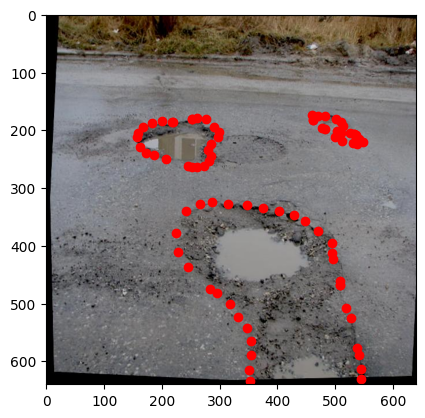

In [54]:
trainDF = trainDF.sample(frac=1).reset_index(drop=True)
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(trainImagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    #* 640 x 640
    xlim = math.ceil(implot.axes.get_xlim()[1])
    ylim = math.ceil(implot.axes.get_ylim()[0])

    with open(os.path.join(trainLabelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            line = [float(line) for line in line.strip().split(" ")[1:]]
            xs, ys = [], []
            for i in range(len(line)):
                xs.append(line[i] * xlim) if i % 2 == 0 else ys.append(line[i] * ylim)
            plt.scatter(xs, ys, color="red")
    plt.show()
    break

---

## Get bounding box from segmentation mask (points) in COCO format

In [55]:
def seg_to_bbox(seg_info):
    _, *points = seg_info.split()
    points = [float(p) for p in points]
    x_min, y_min, x_max, y_max = min(points[0::2]), min(points[1::2]), max(points[0::2]), max(points[1::2])
    return [x_min, y_min, x_max - x_min, y_max - y_min]

----

## Show bounding box

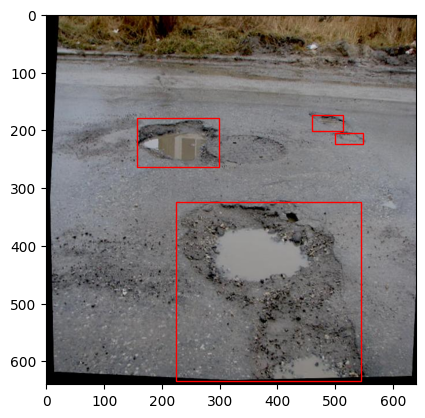

In [56]:
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(trainImagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    xlim = math.ceil(implot.axes.get_xlim()[1])
    ylim = math.ceil(implot.axes.get_ylim()[0])

    with open(os.path.join(trainLabelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            bbox = seg_to_bbox(line)
            for i in range(len(bbox)):
                bbox[i] = bbox[i] * xlim if i % 2 == 0 else bbox[i] * ylim
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color="red")
            plt.gca().add_patch(rect)
    plt.show()
    break

----

## Create complete dataframe

In [80]:
def loadImage(path):
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return np.array([image])

def loadLabel(path, size_x, size_y, bbox=False):
    with open(path, "r") as f:
        lines = f.readlines()
        labels = []
        for line in lines:
            line = seg_to_bbox(line) if bbox else line.strip().split()[1:]
            print(line)
            line = [float(e) for e in line]
            for i in range(len(line)):
                line[i] = line[i] * size_x if i % 2 == 0 else line[i] * size_y
            labels.append(line)
        return np.array([labels])

In [81]:
trainDF["image"] = None
trainDF["seg_label"] = None
trainDF["bbox_label"] = None

for i, row in trainDF.iterrows():
    imagePath = os.path.join(trainImagePath, row["imageFile"] + ".jpg")
    labelPath = os.path.join(trainLabelsPath, row["labelFile"] + ".txt")
    image = loadImage(imagePath)
    seg_label, bbox_label = map(lambda x: loadLabel(labelPath, image[0].shape[1], image[0].shape[0], bbox=x), [False, True])

    trainDF.loc[i, "image"] = image
    trainDF.loc[i, "seg_label"] = seg_label
    trainDF.loc[i, "bbox_label"] = bbox_label

    break

['0.7952796234374999', '0.7306025015625', '0.7947017093750001', '0.7199628406249999', '0.7761960953125', '0.661399259375', '0.7725378171874999', '0.6445356640625', '0.77396365', '0.617329140625', '0.7348605234375001', '0.5834517109374999', '0.7010233625', '0.5574283828125', '0.6711613296875', '0.5422227578125', '0.629816815625', '0.529446609375', '0.587023046875', '0.5226570078125', '0.542043678125', '0.514237240625', '0.4922970484375', '0.5101145046875', '0.448291659375', '0.50477703125', '0.4150558375', '0.5106133374999999', '0.378763071875', '0.5314456890625', '0.3518932515625', '0.5891468671875', '0.357047634375', '0.642463865625', '0.3821658296875', '0.6831865031250001', '0.443861275', '0.7409823156249999', '0.46142527343750006', '0.7525121796875001', '0.49623641718749995', '0.7816178015624999', '0.5181950328125', '0.8176279765625001', '0.5427353140625', '0.8477109468749999', '0.5545814953125', '0.8816755281249999', '0.552601171875', '0.9194623640625', '0.5493300156250001', '0.960

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 4) + inhomogeneous part.

In [ ]:
print(trainDF.head())

                                          imageFile  \
0  pic-201-_jpg.rf.95832ba3432d34d8935a2aa3290fcccc   
1   pic-81-_jpg.rf.f826102d59ca692fc6a7cd93131a448e   
2  pic-163-_jpg.rf.75e0f6d481468e27710dc5bec3a78ea2   
3   pic-98-_jpg.rf.9f186514621bd6868261aefd8bd19a66   
4  pic-176-_jpg.rf.8d87b09b011bb4b479cea2d472354334   

                                          labelFile  \
0  pic-201-_jpg.rf.95832ba3432d34d8935a2aa3290fcccc   
1   pic-81-_jpg.rf.f826102d59ca692fc6a7cd93131a448e   
2  pic-163-_jpg.rf.75e0f6d481468e27710dc5bec3a78ea2   
3   pic-98-_jpg.rf.9f186514621bd6868261aefd8bd19a66   
4  pic-176-_jpg.rf.8d87b09b011bb4b479cea2d472354334   

                                               image  \
0  [[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

 